The goal of this file is to load all flight, fuel, airport, and trajectory data, engineer a feature set by aggregating time-series trajectory statistics (like mean altitude and speed) for each individual fuel-burn interval, and then use Optuna to tune and train a LightGBM regression model to predict the fuel consumed in each interval.

This script provides a complete baseline, but the feature engineering method used is **extremely** inefficient.

Mix ai generated gemini 2.5 pro and thibault lootvoet + copilot

In [1]:
import datetime
import glob
import os
import sys

import lightgbm as lgb
import numpy as np
import optuna
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
def load_data():
    """Loads all parquet files and performs initial type conversion."""
    print("Loading data...")
    base_dir = "../.."
    try:
        # Load the single-file datasets
        flights_df = pd.read_parquet(f"{base_dir}/data/flightlist_train.parquet")
        fuel_df = pd.read_parquet(f"{base_dir}/data/fuel_train.parquet")
        airports_df = pd.read_parquet(f"{base_dir}/data/apt.parquet")

        print("Loaded flight list, fuel, and airport data.")

        # --- Load all trajectory files from the 'flights_train' directory ---

        traj_path = f"{base_dir}/data/flights_train"

        # Check if the directory exists
        if not os.path.isdir(traj_path):
            raise FileNotFoundError(
                f"Trajectory directory not found: '{traj_path}'. "
                "Please ensure it's in the same location as the script."
            )


        # Use glob to find all .parquet files in the directory
        all_traj_files = glob.glob(os.path.join(traj_path, "*.parquet"))
        # all_traj_files = all_traj_files[0:200] # for faster testing, to be removed later

        if not all_traj_files:
            raise FileNotFoundError(
                f"No .parquet files found in '{traj_path}' directory."
            )

        print(
            f"Found {len(all_traj_files)} trajectory files. Loading and concatenating..."
        )

        # Create a list of dataframes, one for each file
        traj_dfs = [pd.read_parquet(f) for f in all_traj_files]

        # Concatenate all of them into a single dataframe
        traj_df = pd.concat(traj_dfs, ignore_index=True)

        print("Trajectory data concatenated successfully.")

        # --- Data Preprocessing and Cleaning ---
        print("Preprocessing data...")

        # Convert all relevant timestamps to datetime objects
        flights_df["takeoff"] = pd.to_datetime(flights_df["takeoff"])
        flights_df["landed"] = pd.to_datetime(flights_df["landed"])

        traj_df["timestamp"] = pd.to_datetime(traj_df["timestamp"])

        fuel_df["start"] = pd.to_datetime(fuel_df["start"])
        fuel_df["end"] = pd.to_datetime(fuel_df["end"])

        # "Quick and Dirty" cleaning: Drop flights with missing aircraft_type
        flights_df = flights_df.dropna(subset=["aircraft_type"])

        return flights_df, traj_df, fuel_df, airports_df

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print(
            "Please make sure all files (apt.parquet, flightlist_train.parquet, fuel_train.parquet) "
            "and the directory (flights_train/) are in the same location."
        )
        sys.exit(1)
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        print("You may need to install a parquet engine, e.g.: pip install pyarrow")
        sys.exit(1)

In [3]:
def create_features(
    flights_df: pd.DataFrame,
    traj_df: pd.DataFrame,
    fuel_df: pd.DataFrame,
    airports_df: pd.DataFrame,
    to_display: bool = False,
) -> tuple[pd.DataFrame, pd.Series, list]:
    """
    Engineers a model-ready feature set (X) and target (y) from the raw data.

    The core logic is built around the `fuel_df`, where each row represents
    a single fuel-burn interval and becomes one sample for the model.

    This function performs three main steps:
    1.  Merges Static Data: Enriches each fuel interval with static
        data from `flights_df` (e.g., aircraft_type) and `airports_df`
        (e.g., origin/destination elevation).
    2.  Filters & Aggregates Time-Series: For each interval, it finds all
        trajectory points from `traj_df` that fall *within* its [start, end]
        timestamp. It then aggregates these points to create summary
        statistics (e.g., mean_altitude, max_TAS, n_points).
    3.  Cleans & Finalizes: Calculates delta features (e.g., altitude_change),
        handles missing values, and formats the final feature matrix `X`
        and target vector `y`.

    Returns:
        X (pd.DataFrame): DataFrame of features for the model.
        y (pd.Series): Series of the target variable (fuel_kg).
        categorical_features (list): List of column names to be
                                     treated as categorical.
    """
    print("Engineering features...")

    # 3.1: Create base table from fuel data
    # Each row in fuel_df is our target sample
    data = fuel_df.copy()

    # 3.2: Add flight-level features
    data = pd.merge(
        data,
        flights_df[["flight_id", "aircraft_type", "origin_icao", "destination_icao"]],
        on="flight_id",
        how="left",
    )

    # 3.3: Add airport features (elevation)
    airports_df_simple = airports_df[["icao", "elevation"]].rename(
        columns={"elevation": "origin_elevation"}
    )
    data = pd.merge(
        data, airports_df_simple, left_on="origin_icao", right_on="icao", how="left"
    )
    airports_df_simple = airports_df_simple.rename(
        columns={"origin_elevation": "dest_elevation"}
    )
    data = pd.merge(
        data,
        airports_df_simple,
        left_on="destination_icao",
        right_on="icao",
        how="left",
    )

    # 3.4: Engineer interval-based trajectory features

    # Give each interval a unique ID to group by
    data["interval_id"] = data.index

    # Merge all trajectory points with all intervals for the same flight
    # This creates a large table, but allows vectorized filtering.
    merged_traj = pd.merge(
        traj_df, data[["flight_id", "start", "end", "interval_id"]], on="flight_id"
    )

    # Filter: Keep only trajectory points that fall *within* the [start, end] of a fuel interval
    filtered_traj = merged_traj[
        (merged_traj["timestamp"] >= merged_traj["start"])
        & (merged_traj["timestamp"] <= merged_traj["end"])
    ].copy()

    # 3.5: Aggregate trajectory features by interval
    print("Aggregating trajectory features...")

    # Sort by time to get first/last points correctly
    filtered_traj.sort_values(by=["interval_id", "timestamp"], inplace=True)

    # Simple aggregates
    agg_features = filtered_traj.groupby("interval_id").agg(
        mean_altitude=("altitude", "mean"),
        max_altitude=("altitude", "max"),
        mean_TAS=("TAS", "mean"),
        max_TAS=("TAS", "max"),
        mean_groundspeed=("groundspeed", "mean"),
        mean_vertical_rate=("vertical_rate", "mean"),
        n_points=("timestamp", "count"),
    )

    # Get features from the *first* and *last* point in the interval
    first_points = filtered_traj.groupby("interval_id").first()
    last_points = filtered_traj.groupby("interval_id").last()

    delta_features = pd.DataFrame(index=agg_features.index)
    delta_features["altitude_change"] = (
        last_points["altitude"] - first_points["altitude"]
    )
    delta_features["time_in_interval_s"] = (
        last_points["timestamp"] - first_points["timestamp"]
    ).dt.total_seconds()

    # 3.6: Merge aggregated features back into the main table
    data = data.merge(agg_features, on="interval_id", how="left")
    data = data.merge(delta_features, on="interval_id", how="left")

    # 3.7: Add simple features
    # This is the 'reported' duration, which is a key predictor
    data["interval_duration_s"] = (data["end"] - data["start"]).dt.total_seconds()

    # --- 4. Final Processing ---
    print("Finalizing dataset...")

    # Define feature set
    # We must convert aircraft_type to a category for LightGBM
    data["aircraft_type"] = data["aircraft_type"].astype("category")

    # "Quick and Dirty" cleaning:
    # Drop rows where we have no fuel target
    data = data.dropna(subset=["fuel_kg"])
    # Drop rows where interval duration is zero or negative
    data = data[data["interval_duration_s"] > 0]
    # Drop intervals that had no trajectory points (n_points is NaN after left merge)
    data = data.dropna(subset=["n_points"])

    # Fill any other remaining NaNs (e.g., missing TAS) with 0
    # A better approach would be interpolation or 0-filling only specific columns
    data["aircraft_type"] = data["aircraft_type"].astype("object")
    data["aircraft_type"] = data["aircraft_type"].fillna("UNKNOWN")
    data["aircraft_type"] = data["aircraft_type"].astype("category")

    numeric_cols = data.select_dtypes(include=np.number).columns
    data[numeric_cols] = data[numeric_cols].fillna(0)

    features = [
        "interval_duration_s",
        "aircraft_type",
        "origin_elevation",
        "dest_elevation",
        "mean_altitude",
        "max_altitude",
        "mean_TAS",
        "max_TAS",
        "mean_groundspeed",
        "mean_vertical_rate",
        "n_points",
        "altitude_change",
        "time_in_interval_s",
    ]
    categorical_features = ["aircraft_type"]
    target = "fuel_kg"

    # Filter out any rows that somehow still have NaN/Inf in features
    X = data[features]
    y = data[target]

    # Define our numeric features (which is all features except the categorical ones)
    numeric_features = [f for f in features if f not in categorical_features]

    # Apply numeric-only cleaning (replace inf, fillna)
    # ONLY to the numeric columns.
    X[numeric_features] = (
        X[numeric_features].replace([np.inf, -np.inf], np.nan).fillna(0)
    )

    print(f"Dataset finalized. Total samples: {len(X)}")
    print(f"Features: {features}")

    if to_display:
        display(X.head())
        display(y.head())
    print(f"Categorical features: {categorical_features}")

    return X, y, categorical_features

In [ ]:
def train_model(X, y, categorical_features, n_trials=50, to_load=None) -> str:
    """Sets up Optuna to find the best LightGBM hyperparameters."""

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    def objective(trial):
        """Optuna objective function to minimize."""

        # Hyperparameters to tune
        params = {
            "objective": "regression_l1",
            "metric": "rmse",
            "n_estimators": 1000,
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 20, 300),
            "max_depth": trial.suggest_int("max_depth", 5, 20),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
            "verbose": -1,
            "n_jobs": -1,
            "seed": 42,
        }

        model = lgb.LGBMRegressor(**params)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            callbacks=[lgb.early_stopping(100, verbose=False)],
            categorical_feature=categorical_features,
        )

        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        return rmse

    print("\n--- Starting Optuna Hyperparameter Search ---")
    if to_load:
        study = optuna.load_study(study_name=to_load, storage="sqlite:///mydb.sqlite3")
        print(f"Loaded existing study '{to_load}' with {len(study.trials)} trials.")
    else:
        study = optuna.create_study(direction="minimize", study_name=f"LightGBM Fuel Burn Prediction {datetime.datetime.now().isoformat()}", storage="sqlite:///mydb.sqlite3", load_if_exists=True)

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("\nOptuna search finished.")
    print(f"Best RMSE on validation set: {study.best_value:.4f}")
    print("Best hyperparameters:")
    print(study.best_params)



    # Final model evaluation
    print("\n--- Training Final Model on All Training Data ---")

    # Add n_estimators from the best trial (or use the fitted one from early stopping)
    best_params = study.best_params
    best_params["n_estimators"] = 1000  # We will use early stopping

    final_model = lgb.LGBMRegressor(
        objective="regression_l1",
        metric="rmse",
        seed=42,
        n_jobs=-1,
        verbose=-1,
        **best_params,
    )

    final_model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
        callbacks=[lgb.early_stopping(100, verbose=True)],
        categorical_feature=categorical_features,
    )

    val_preds = final_model.predict(X_val)
    final_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    print(f"\nFinal Model Validation RMSE: {final_rmse:.4f}")

    # Show feature importances
    try:
        lgb.plot_importance(final_model, max_num_features=20)
        import matplotlib.pyplot as plt

        plt.title("Feature Importances")
    except Exception as e:
        print(
            f"\nCould not plot feature importance. (Is matplotlib installed?) Error: {e}"
        )

    return study.study_name

In [ ]:
def test_model(X, y, categorical_features, model_to_load, storage="sqlite:///mydb.sqlite3"):
    """Loads the best model from the Optuna study."""
    study = optuna.load_study(study_name=model_to_load, storage=storage)
    best_trial = study.best_trial
    print(f"Best trial: {best_trial.number}")
    print(f"Best value (RMSE): {best_trial.value:.4f}")
    print("Best hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"  {key}: {value}")

    # Train final model with best hyperparameters
    final_model = lgb.LGBMRegressor(
        objective="regression_l1",
        metric="rmse",
        seed=42,
        n_jobs=-1,
        verbose=-1,
        **best_trial.params,
    )
    final_model.fit(X, y, categorical_feature=categorical_features)

    # print rmse on the training set
    train_preds = final_model.predict(X)
    train_rmse = np.sqrt(mean_squared_error(y, train_preds))
    print(f"\nFinal Model Training RMSE: {train_rmse:.4f}")
    
    # Show feature importances
    try:
        lgb.plot_importance(final_model, max_num_features=20)
        import matplotlib.pyplot as plt

        plt.title("Feature Importances")
    except Exception as e:
        print(
            f"\nCould not plot feature importance. (Is matplotlib installed?) Error: {e}"
        )

In [6]:
# nécessité de faire du feature engineering i.e. prendre des moyennes ou qqch parce que là ce n'est pas possible
# example approche actuelle: premier prompt de https://gemini.google.com/app/2db88ca378891ac5

In [7]:
flights, traj, fuel, airports = load_data()

Loading data...
Loaded flight list, fuel, and airport data.
Found 5868 trajectory files. Loading and concatenating...
Trajectory data concatenated successfully.
Preprocessing data...


In [8]:
# print the number of rows in each dataframe
print(f"Flights: {len(flights)} rows")
print(f"Trajectories: {len(traj)} rows")
print(f"Fuel: {len(fuel)} rows")
print(f"Airports: {len(airports)} rows")

Flights: 11037 rows
Trajectories: 65550915 rows
Fuel: 131530 rows
Airports: 8787 rows


In [ ]:
# keep only the first 150 rows of fuel for faster testing (130k rows is a bit too much)
fuel_short = fuel.iloc[:150].reset_index(drop=True)

X_features, y_target, categorical_cols = create_features(flights, traj, fuel_short, airports, to_display=True)

print(len(X_features), "samples in the feature set")

Engineering features...
Aggregating trajectory features...
Finalizing dataset...
Dataset finalized. Total samples: 85
Features: ['interval_duration_s', 'aircraft_type', 'origin_elevation', 'dest_elevation', 'mean_altitude', 'max_altitude', 'mean_TAS', 'max_TAS', 'mean_groundspeed', 'mean_vertical_rate', 'n_points', 'altitude_change', 'time_in_interval_s']


/tmp/ipykernel_13030/1316261788.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_features] = (


,interval_duration_s,aircraft_type,origin_elevation,dest_elevation,mean_altitude,max_altitude,mean_TAS,max_TAS,mean_groundspeed,mean_vertical_rate,n_points,altitude_change,time_in_interval_s
0,1800.040,B789,69.0,-11.0,35988.585001,35999.9280,0.0,0.0,472.013723,-3.360382,3078.0,24.9936,1800.040
1,899.739,B789,69.0,-11.0,35989.290344,35999.9280,0.0,0.0,484.703549,-29.862213,1790.0,-24.9936,899.739
2,1799.959,B789,69.0,-11.0,35988.990605,35999.9280,0.0,0.0,511.885794,-36.040854,3480.0,0.0000,1799.959
3,900.123,B789,69.0,-11.0,35988.474983,36024.9216,0.0,0.0,506.388982,-34.457429,1750.0,24.9936,900.123
4,899.723,B789,69.0,-11.0,29491.527367,35999.9280,0.0,0.0,467.748289,-1531.863118,1518.0,-20774.8632,899.723


0    2500.0
1    1200.0
2    2500.0
3    1300.0
4     600.0
Name: fuel_kg, dtype: float64

Categorical features: ['aircraft_type']
85 samples in the feature set


Best trial: 0
Best value (RMSE): 290.1797
Best hyperparameters:
  learning_rate: 0.0659597493401273
  num_leaves: 244
  max_depth: 10
  subsample: 0.9870343357596183
  colsample_bytree: 0.899672146191584
  reg_alpha: 0.539176214340863
  reg_lambda: 0.7311175088478454

Final Model Training RMSE: 502.3277

Saved feature importance plot to 'feature_importance.png'


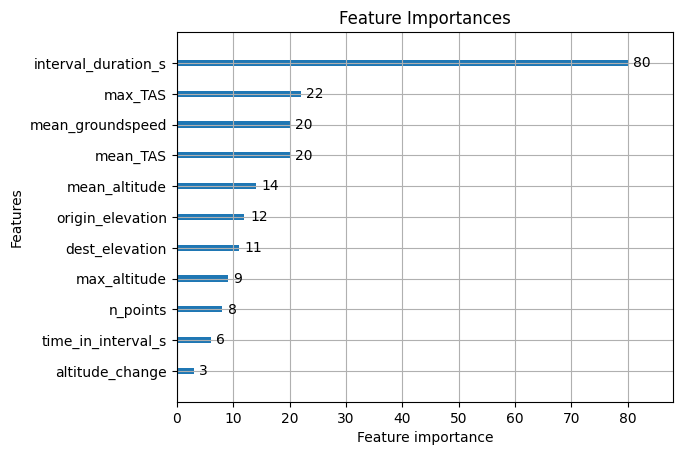

In [ ]:
model_name = train_model(X_features, y_target, categorical_cols, n_trials=100)
# to load the dashboard do: uv run optuna-dashboard sqlite:///mydb.sqlite3
test_model(
    X_features,
    y_target,
    categorical_cols,
    model_to_load=model_name,
    storage="sqlite:///mydb.sqlite3",
)